In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
import textwrap

In [2]:
from metagov import at2df # Small custom wrapper functions for the Airtable library

In [3]:
# Output settings
SAVEDIR = 'tmp'
DEFAULT_COLOR = '#66C2A5'
DEFAULT_SIZE = (5, 5)
sns.set(rc={"figure.figsize":DEFAULT_SIZE})
sns.set(font_scale=1.25)
kwargs_svg = {'format': 'svg', 'bbox_inches': 'tight', 'transparent': True}
kwargs_png = {'format': 'png', 'bbox_inches': 'tight', 'dpi': 600, 'transparent': True}

def save_figure(plt, name):
    fname = f"{SAVEDIR}/constitutional model - {name}"
    plt.savefig(f"{fname}.png", **kwargs_png)
    plt.savefig(f"{fname}.svg", **kwargs_svg)

# What is in DAO Constitutions?
This notebook visualizes data collected in the [Constitutional Model table]() of [Metagov's](https://metagov.org/) [Govbase](https://govbase.metagov.org/) database. The data set contains coded data describing the content and structure of 19+ governing documents.

## Import data
Import Constitutional Models table and link related project information from the Projects table.

In [4]:
at = at2df.get_airtable()

In [5]:
df = at2df.get_table_as_df(at, 'Constitutional Model')
df_projects = at2df.get_table_as_df(at, 'Projects', kwargs={'view': 'DAO ecosystem projects'})
df['On-chain components key'] = df['On-chain components']
df['On-chain components'] = df['On-chain components key'].apply(
    lambda values: [df_projects.at[v, 'Project name'] for v in values] if isinstance(values, list) else np.nan)

In [6]:
def plot_coded_column(df_all, col, label='', orient='h', size=None, plotType='bar'):
    """Plot frequency of unique list items for coded columns
    Handle columns with list values differently from columns with single values"""
    
    df = df_all.copy(deep=True)
    isListCol = any([isinstance(d, list) for d in df[col]])
    
    if isListCol:
        # Make sure all values in column are lists
        df[col] = df[col].apply(lambda d: d if isinstance(d, list) else [])

        # One-hot encode column of lists
        mlb = MultiLabelBinarizer(sparse_output=True)
        df_onehot = pd.DataFrame.sparse.from_spmatrix(
            mlb.fit_transform(df[col]),
            index=df.index,
            columns=mlb.classes_)

        # Get count for each unique item
        df_sum = pd.DataFrame(df_onehot.sum()).sort_values(0, axis=0, ascending=False).transpose()
    else:
        df_sum = pd.DataFrame(df[col].value_counts()).transpose()
    
    # Resize plot if needed
    if size is not None:
        sns.set(rc={"figure.figsize": size})
        sns.set(font_scale=1.25)
    
    plt.plot()
    
    if plotType == 'bar':
        # Plot bar chart of unique list items
        ax = sns.barplot(data=df_sum, orient=orient, color=DEFAULT_COLOR)

        # Formatting
        if orient == 'h':
            plt.ylabel(label)
            labels = ["\n".join(textwrap.wrap(c, width=30)) for c in df_sum.columns]
            ax.set(yticklabels=labels)
            plt.xlabel('Count')
            if not isListCol:
                plt.xlim((0, df_sum.sum().sum() + 1))
        else:
            plt.ylabel('Count')
            plt.xlabel("\n".join(textwrap.wrap(label, 50)))
            labels = ["\n".join(textwrap.wrap(c, width=25)) for c in df_sum.columns]
            ax.set(xticklabels=labels)
            if not isListCol:
                plt.ylim((0, df_sum.sum().sum() + 1))
    
    elif plotType == 'pie':
        # Plot pie chart of unique list items
        fig = plt.pie(df_sum.squeeze(), labels=df_sum.columns, 
                      colors=sns.color_palette("Set2"), wedgeprops=dict(width=0.5))
        plt.title(label)
    
    save_figure(plt, label)
    
    if size is not None:
        sns.set(rc={"figure.figsize": DEFAULT_SIZE})
        sns.set(font_scale=1.25)

## Document structure

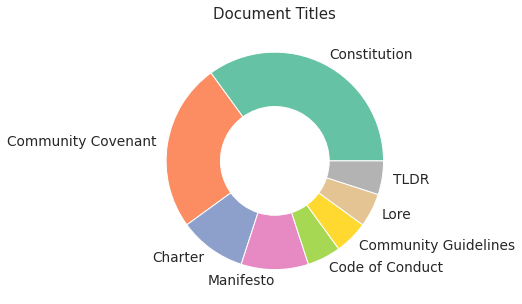

In [7]:
plot_coded_column(df, 'Document title', label='Document Titles', plotType='pie')

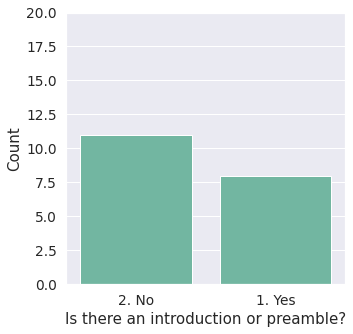

In [8]:
plot_coded_column(df, 'preamble', label='Is there an introduction or preamble?', orient='v')

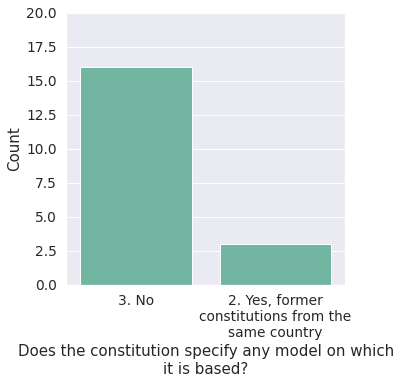

In [9]:
plot_coded_column(df, 'model', label='Does the constitution specify any model on which it is based?', orient='v')

## Rights, values, and goals

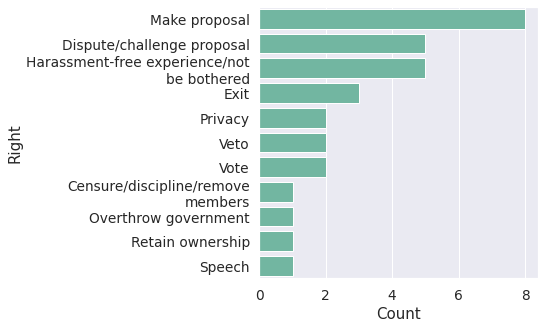

In [10]:
plot_coded_column(df, 'rights_code', label='Right')

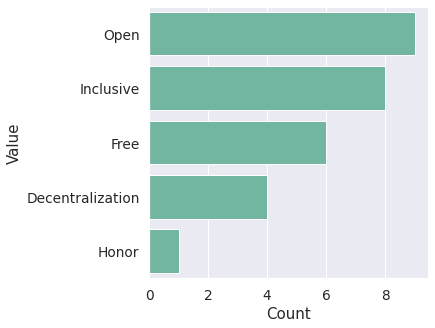

In [11]:
plot_coded_column(df, 'values_code', label='Value')

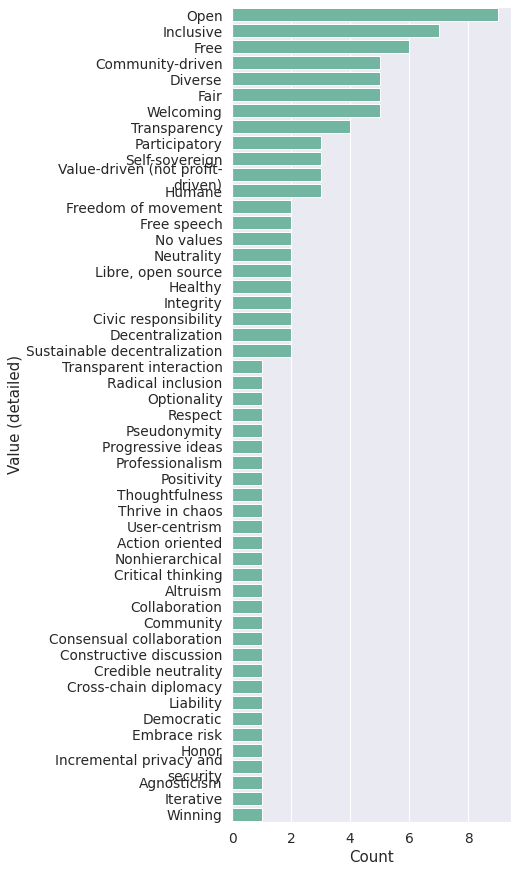

In [12]:
plot_coded_column(df, 'values', label='Value (detailed)', size=(5,15))

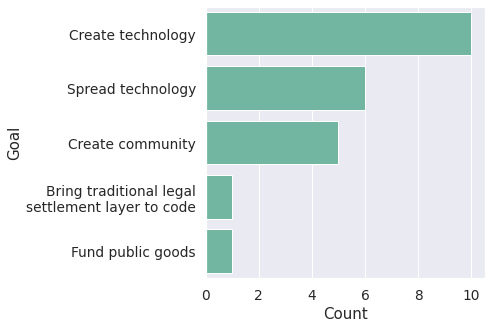

In [13]:
plot_coded_column(df, 'goals_code', label='Goal')

## Constitutional provisions

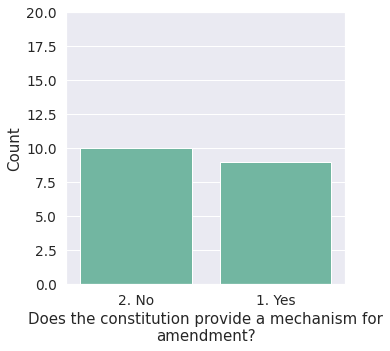

In [14]:
plot_coded_column(df, 'amend', label='Does the constitution provide a mechanism for amendment?', orient='v')

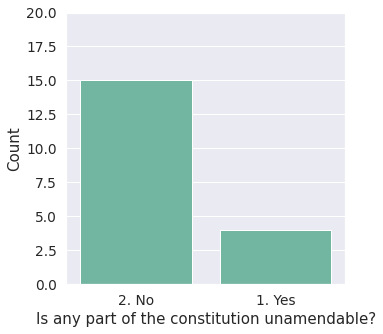

In [15]:
plot_coded_column(df, 'unamend', label='Is any part of the constitution unamendable?', orient='v')

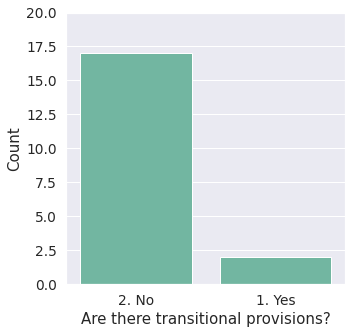

In [16]:
plot_coded_column(df, 'transprov', label='Are there transitional provisions?', orient='v')

## Supplementary information
Not specified in constitution; drawn from other sources.

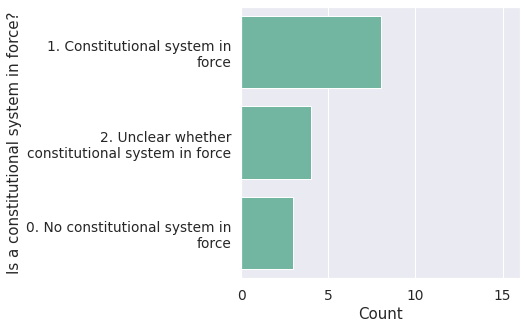

In [17]:
plot_coded_column(df, 'c_inforce', label='Is a constitutional system in force?')

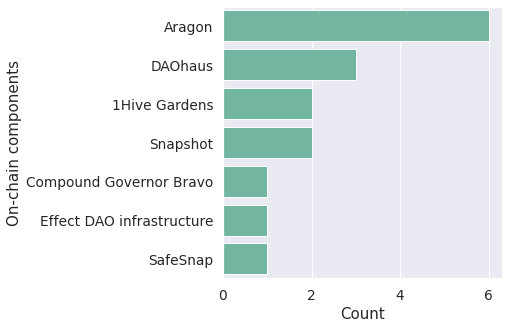

In [18]:
plot_coded_column(df, 'On-chain components', label='On-chain components')